# Implementación del Transformer

Primero que nada, se importan las bibliotecas necesarias para implementar y entrenar el modelo. PyTorch (torch, torch.nn, torch.nn.functional) se utiliza para la construcción del modelo, la gestión de datos y el cálculo de funciones de pérdida. TQDM permite incluir barras de progreso durante el entrenamiento para visualizar su avance. Las bibliotecas Seaborn y Matplotlib se emplean para generar gráficos y analizar visualmente las puntuaciones de atención. Además, se importa NumPy para manipulación de datos numéricos y la clase Transformer desde el módulo `model.Transformer`, la cual contiene la lógica principal del modelo.

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F

import torch.optim as optim
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [3]:
from model.Transformer import Transformer

# Predicción de secuencias de números

### Creación del dataset

En este apartado se crea un conjunto de datos con secuencias numéricas consecutivas. Para ello, se generan 100,000 secuencias que comienzan en un número aleatorio entre 1 y 9, y que se incrementan hasta 9. Cada secuencia se almacena como un string. Finalmente, se calcula la longitud promedio de las secuencias para obtener información sobre el dataset.

Como es evidente, tan solo habrán 10 posibles secuencias únicas. No obstante, introducimos esta redundancia para agilizar el entrenamiento en un menor número de épocas, y asegurarnos así de que el modelo está funcionando correctamente antes de aplicarlo a un dataset más complejo.

In [4]:
sequences = []
n_sequences = 100000

In [5]:
for _ in range(n_sequences):
    start = torch.randint(1, 10, (1,))
    seq = ""
    for i in range(start, 10):
        seq += str(i)

    sequences.append(seq)

In [6]:
mean = sum([len(seq) for seq in sequences]) / n_sequences
print(f"Longitud media de las secuencias: {mean}")

Longitud media de las secuencias: 5.00701


La clase SequenceDataset implementa un dataset personalizado para gestionar las secuencias generadas. Define un vocabulario basado en los dígitos del 0 al 9 y proporciona métodos para convertir caracteres en índices (char2idx) y viceversa (idx2char). El método __getitem__ convierte cada secuencia en una lista de índices, mientras que collate_fn permite el padding de las secuencias para obtener batches uniformes y realiza una codificación one-hot para cada carácter de la secuencia.

In [7]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [8]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        self.vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        self.char2idx = {char: idx for idx, char in enumerate(self.vocab)}
        self.idx2char = {idx: char for idx, char in enumerate(self.vocab)}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq = [self.char2idx[char] for char in seq]
        return torch.tensor(seq)

    def collate_fn(self, batch):
        batch = pad_sequence(batch, batch_first=True)
        batch = F.one_hot(batch, num_classes=len(self.vocab))
        return batch

A continuación, se muestra un ejemplo de secuencia generada:

In [9]:
dataset = SequenceDataset(sequences)
print(dataset.__getitem__(0))

tensor([7, 8, 9])


Se utiliza un DataLoader para gestionar el dataset de manera eficiente, dividiéndolo en batches del tamaño definido (BATCH_SIZE = 32). Este DataLoader utiliza la función de colación definida en la clase SequenceDataset para preparar cada batch con padding y codificación one-hot. Un ejemplo de un batch procesado se imprime para verificar su compatibilidad con el modelo Transformer.

In [10]:
BATCH_SIZE = 32

In [11]:
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=dataset.collate_fn
)

In [12]:
for batch in dataloader:
    print(batch.size())
    break

torch.Size([32, 9, 10])


Ahora sí, creamos una instancia del modelo Transformer utilizando parámetros específicos, como el tamaño del vocabulario (vocab_dim), la dimensión oculta (hidden_dim), la profundidad del encoder (enc_depth) y la profundidad del decoder (dec_depth). Debido a que son secuencias de número del 1 al 9, y que el caracter de padding es el token 0, el tamaño del vocabulario será 10. Además, como se utiliza una representación one-hot para los caracteres, la dimensión de entrada y salida del modelo será igual al tamaño del vocabulario.

In [13]:
transformer = Transformer(
                vocab_dim=10, 
                hidden_dim=10,
                enc_depth=5,
                dec_depth=1
            )

output = transformer(batch.float(), batch.float())[0]
output = torch.argmax(output, dim=-1)

target = batch[0]
target = torch.argmax(target, dim=-1)

print("Predicción:", output)
print("Target:", target)

Predicción: tensor([5, 4, 1, 5, 9, 1, 9, 1, 9])
Target: tensor([9, 0, 0, 0, 0, 0, 0, 0, 0])


Se comprueba en el resultado al chunck anterior como el modelo parece estar funcionando con normalidad. Solo queda ahora comprobar que este es capaz de predecir correctamente las secuencias numéricas.

### Entrenamiento del modelo

El modelo Transformer se entrenará utilizando `PyTorch` en un dispositivo GPU. Durante el entrenamiento, cada batch se divide en entradas (inputs) y objetivos (targets), y se calcula la pérdida usando CrossEntropyLoss. El optimizador Adam actualiza los parámetros del modelo en función del gradiente calculado durante el paso hacia atrás. El entrenamiento se realiza durante un número definido de épocas (EPOCHS = 10), y la pérdida promedio de cada época se imprime para monitorear el progreso.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
VOCAB_SIZE = 10
HIDDEN_DIM = 10
NUM_HEADS = 2
ENC_DEPTH = 5
DEC_DEPTH = 1

In [16]:
transformer = Transformer(
    vocab_dim=VOCAB_SIZE, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=NUM_HEADS, 
    enc_depth=ENC_DEPTH, 
    dec_depth=DEC_DEPTH
).to(device)

In [17]:
EPOCHS = 10
LEARNING_RATE = 1e-3

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

In [59]:
for epoch in range(EPOCHS):
    transformer.train()
    epoch_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch = batch.to(device)
        inputs = batch[:, :-1, :]
        targets = batch[:, 1:, :]

        outputs = transformer(inputs.float(), targets.float(), teacher_forcing_ratio=0.5)

        outputs = outputs.reshape(-1, VOCAB_SIZE)
        targets = torch.argmax(targets, dim=-1).reshape(-1)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss / len(dataloader):.4f}")

torch.save(transformer.state_dict(), "transformer_model.pth")
print("Modelo entrenado y guardado en transformer_model.pth")

Epoch 1/10: 100%|██████████| 3125/3125 [01:45<00:00, 29.68it/s]


Epoch 1/10, Loss: 0.5105


Epoch 2/10: 100%|██████████| 3125/3125 [01:22<00:00, 38.00it/s]


Epoch 2/10, Loss: 0.0542


Epoch 3/10: 100%|██████████| 3125/3125 [01:28<00:00, 35.13it/s]


Epoch 3/10, Loss: 0.0095


Epoch 4/10: 100%|██████████| 3125/3125 [01:44<00:00, 29.99it/s]


Epoch 4/10, Loss: 0.0021


Epoch 5/10: 100%|██████████| 3125/3125 [01:36<00:00, 32.32it/s]


Epoch 5/10, Loss: 0.0005


Epoch 6/10: 100%|██████████| 3125/3125 [01:51<00:00, 28.05it/s]


Epoch 6/10, Loss: 0.0001


Epoch 7/10: 100%|██████████| 3125/3125 [01:36<00:00, 32.27it/s]


Epoch 7/10, Loss: 0.0044


Epoch 8/10: 100%|██████████| 3125/3125 [01:29<00:00, 34.88it/s]


Epoch 8/10, Loss: 0.0000


Epoch 9/10: 100%|██████████| 3125/3125 [01:25<00:00, 36.45it/s]


Epoch 9/10, Loss: 0.0000


Epoch 10/10: 100%|██████████| 3125/3125 [01:32<00:00, 33.72it/s]

Epoch 10/10, Loss: 0.0000
Modelo entrenado y guardado en transformer_model.pth


Una vez finalizado el entrenamiento, el modelo entrenado se guarda en un archivo denominado transformer_model.pth utilizando torch.save. Este paso asegura que el modelo pueda reutilizarse o evaluarse posteriormente sin necesidad de entrenarlo nuevamente.

### Evaluación del modelo

Para evaluar el modelo entrenado, se carga desde el archivo guardado y se establece en modo de evaluación. Se genera un batch de datos de prueba y se pasa al modelo para obtener las predicciones. Las puntuaciones de atención de una de las capas del encoder se visualizan utilizando mapas de calor (heatmaps) generados con Seaborn y Matplotlib. Estas visualizaciones permiten analizar cómo el modelo asigna importancia a diferentes elementos de las secuencias de entrada.

In [28]:
transformer = Transformer(
    vocab_dim=VOCAB_SIZE, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=NUM_HEADS, 
    enc_depth=ENC_DEPTH, 
    dec_depth=DEC_DEPTH
).to(device)

transformer.load_state_dict(torch.load("transformer_model.pth"))
transformer.eval()

Transformer(
  (encoder): ModuleList(
    (0-4): 5 x Encoder(
      (attention_head): AttentionHead(
        (attention_heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (Q): Linear(in_features=10, out_features=10, bias=False)
            (K): Linear(in_features=10, out_features=10, bias=False)
            (V): Linear(in_features=10, out_features=10, bias=False)
            (softmax): Softmax(dim=-1)
          )
        )
        (fc): Linear(in_features=20, out_features=10, bias=True)
      )
      (layer_norm_1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      (fc): Linear(in_features=10, out_features=10, bias=True)
      (layer_norm_2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): ModuleList(
    (0): Decoder(
      (self_attention_head): AttentionHead(
        (attention_heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (Q): Linear(in_features=10, out_features=10, bias=False)
            (K): Linear(in_fe

In [18]:
for batch in dataloader:
    print(batch.size())
    break

torch.Size([32, 9, 10])


In [18]:
batch = batch.to(device)
inputs = batch[:, :-1, :]
targets = batch[:, 1:, :]

outputs = transformer(inputs.float(), torch.randn(32, 9, 10).to(device), teacher_forcing_ratio=0)

encoder = transformer.encoder[-1]
scores, att = encoder.attention_head.attention_heads[0](inputs.float())

In [19]:
outputs = torch.argmax(outputs, dim=-1)
targets = torch.argmax(targets, dim=-1)
inputs = torch.argmax(inputs, dim=-1)

In [32]:
scores = scores[0]

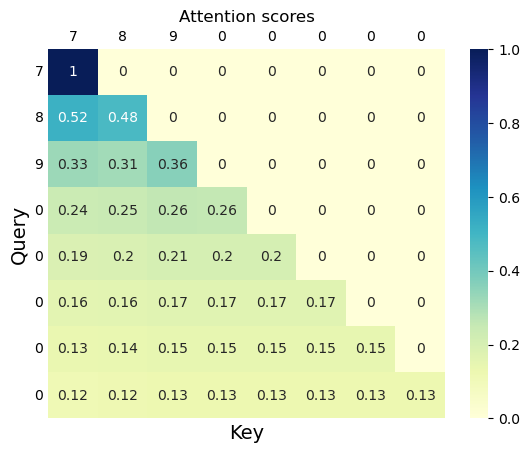

In [33]:
sns.heatmap(scores.cpu().detach().numpy(), annot=True, cmap="YlGnBu")
plt.title("Attention scores")

input_items = [i.item() for i in inputs[0]]
plt.xticks(ticks=np.arange(len(input_items)) + 0.5, labels=input_items, ha='center')
plt.yticks(ticks=np.arange(len(input_items)) + 0.5, labels=input_items, rotation=0, va='center')

plt.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
plt.tick_params(axis='y', length=0)

plt.xlabel("Key", fontsize=14)
plt.ylabel("Query", fontsize=14)

plt.show()

Si ahora comparamos las secuencias generadas con las esperadas, obtenemos el siguiente resultado:

In [34]:
for i in range(5):
    print("Input:", inputs[i])
    print("Predicción:", outputs[i])
    print("Target:", targets[i])
    print('')

Input: tensor([7, 8, 9, 0, 0, 0, 0, 0])
Predicción: tensor([8, 9, 0, 0, 0, 0, 0, 0, 0])
Target: tensor([8, 9, 0, 0, 0, 0, 0, 0])

Input: tensor([1, 2, 3, 4, 5, 6, 7, 8])
Predicción: tensor([2, 3, 4, 5, 6, 7, 8, 9, 0])
Target: tensor([2, 3, 4, 5, 6, 7, 8, 9])

Input: tensor([9, 0, 0, 0, 0, 0, 0, 0])
Predicción: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])
Target: tensor([0, 0, 0, 0, 0, 0, 0, 0])

Input: tensor([6, 7, 8, 9, 0, 0, 0, 0])
Predicción: tensor([7, 8, 9, 0, 0, 0, 0, 0, 0])
Target: tensor([7, 8, 9, 0, 0, 0, 0, 0])

Input: tensor([6, 7, 8, 9, 0, 0, 0, 0])
Predicción: tensor([7, 8, 9, 0, 0, 0, 0, 0, 0])
Target: tensor([7, 8, 9, 0, 0, 0, 0, 0])



# Suma de números

Probaremso ahora a entrenar un modelo más complejo, el cual será capaz de realizar sumas entre números de tres dígitos.

### Creación del dataset

En este caso, se genera un nuevo dataset para resolver sumas de números enteros. Cada ejemplo consiste en dos números aleatorios entre 100 y 499, seguidos de su suma y el carácter especial e como terminador. El dataset utiliza un vocabulario ampliado que incluye los caracteres +, =, y e, además de los dígitos.

In [21]:
sequences = []
n_sequences = 100000

In [22]:
for _ in range(n_sequences):
    num1 = torch.randint(100, 499, (1,))
    num2 = torch.randint(100, 499, (1,))
    result = num1 + num2

    sequences.append(f"{num1.item()}+{num2.item()}={result.item()}e")

Algunos ejemplos de secuencias generadas son las siguientes:

In [23]:
sequences[:5]

['274+413=687e',
 '436+476=912e',
 '373+272=645e',
 '126+316=442e',
 '276+421=697e']

Como en la sección anterior, se crea un dataset personalizado para gestionar las secuencias generadas. La clase SequenceDataset extiende Dataset, y se utilizan los mismos métodos de colación y conversión de caracteres a índices para preparar los datos para el modelo que en la sección anterior.

In [25]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        self.vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '=', 'e']
        self.char2idx = {char: idx for idx, char in enumerate(self.vocab)}
        self.idx2char = {idx: char for idx, char in enumerate(self.vocab)}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq = [self.char2idx[char] for char in seq]
        return torch.tensor(seq)

    def collate_fn(self, batch):
        batch = pad_sequence(batch, batch_first=True)
        batch = F.one_hot(batch, num_classes=len(self.vocab))
        return batch

Un ejemplo de secuencia generada expresada según los índices de sus tokens en el vocabulario es la siguiente:

In [26]:
dataset = SequenceDataset(sequences)
print(dataset.__getitem__(0))

tensor([ 2,  7,  4, 10,  4,  1,  3, 11,  6,  8,  7, 12])


Ahora sí, se crea un DataLoader para gestionar el dataset de sumas. Este DataLoader utiliza la función de colación definida en la clase SequenceDataset para preparar cada batch con padding y codificación one-hot.

In [27]:
BATCH_SIZE = 32

In [28]:
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=dataset.collate_fn
)

Un ejemplo de un batch procesado se imprime para verificar su compatibilidad con el modelo Transformer, el cual tendrá un `vocab_size`, y por tanto un `hidden_dim`, de 13, al usarse la representación one-hot de los caracteres.

In [29]:
for batch in dataloader:
    print(batch.size())
    break

torch.Size([32, 12, 13])


De nuevo, definimos el modelo ajustandonos al nuevo vocabulario y, debido a la complejidad, modificamos la arquitectura del mismo para que este tenga 4 encoders y 4 decoders. Se comprueba además que el modelo pueda procesar correctamente una muestra de datos.

In [30]:
transformer = Transformer(
                vocab_dim=13, 
                hidden_dim=13,
                enc_depth=4,
                dec_depth=4
            )

output = transformer(batch.float(), batch.float())[0]
output = torch.argmax(output, dim=-1)

target = batch[0]
target = torch.argmax(target, dim=-1)

print("Predicción:", output)
print("Target:", target)

Predicción: tensor([12,  1, 12, 12, 11,  1, 11, 11, 10,  1, 12,  1])
Target: tensor([ 1,  6,  0, 10,  4,  4,  2, 11,  6,  0,  2, 12])


### Entrenamiento del modelo

Ahora sí, procedemos con el entrenamiento:

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [32]:
VOCAB_SIZE = 13
HIDDEN_DIM = 13
NUM_HEADS = 2
ENC_DEPTH = 4
DEC_DEPTH = 4

In [33]:
transformer = Transformer(
    vocab_dim=VOCAB_SIZE, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=NUM_HEADS, 
    enc_depth=ENC_DEPTH, 
    dec_depth=DEC_DEPTH
).to(device)

In [34]:
EPOCHS = 10
LEARNING_RATE = 1e-3

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

Vease que el modelo tan sólo recibirá como entrada los primeros 8 caracteres de la secuencia. Esto es, la secuencia original hasta el igual, con este incluído. El modelo deberá predecir la suma de los dos números que se encuentran antes del igual y finalizar cuando se imprima el carácter especial `e`.

In [36]:
for epoch in range(EPOCHS):
    transformer.train()
    epoch_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch = batch.to(device)
        inputs = batch[:, :8, :]
        targets = batch[:, 8:, :]

        outputs = transformer(inputs.float(), targets.float(), teacher_forcing_ratio=0.5)

        outputs = outputs.reshape(-1, VOCAB_SIZE)
        targets = torch.argmax(targets, dim=-1).reshape(-1)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss / len(dataloader):.4f}")

torch.save(transformer.state_dict(), "transformer_model.pth")
print("Modelo entrenado y guardado en transformer_model.pth")

Epoch 1/10: 100%|██████████| 3125/3125 [04:39<00:00, 11.18it/s]


Epoch 1/10, Loss: 1.6399


Epoch 2/10: 100%|██████████| 3125/3125 [04:17<00:00, 12.15it/s]


Epoch 2/10, Loss: 1.4634


Epoch 3/10: 100%|██████████| 3125/3125 [04:13<00:00, 12.33it/s]


Epoch 3/10, Loss: 1.4332


Epoch 4/10: 100%|██████████| 3125/3125 [04:20<00:00, 12.00it/s]


Epoch 4/10, Loss: 1.3805


Epoch 5/10: 100%|██████████| 3125/3125 [04:58<00:00, 10.47it/s]


Epoch 5/10, Loss: 1.2786


Epoch 6/10: 100%|██████████| 3125/3125 [06:10<00:00,  8.44it/s]


Epoch 6/10, Loss: 1.2150


Epoch 7/10: 100%|██████████| 3125/3125 [05:23<00:00,  9.65it/s]


Epoch 7/10, Loss: 1.1085


Epoch 8/10: 100%|██████████| 3125/3125 [05:16<00:00,  9.88it/s]


Epoch 8/10, Loss: 1.0069


Epoch 9/10: 100%|██████████| 3125/3125 [04:45<00:00, 10.94it/s]


Epoch 9/10, Loss: 0.9551


Epoch 10/10: 100%|██████████| 3125/3125 [04:23<00:00, 11.84it/s]


Epoch 10/10, Loss: 0.9738
Modelo entrenado y guardado en transformer_model.pth


### Evaluación del modelo

El modelo entrenado se evalúa utilizando mapas de calor para analizar las puntuaciones de atención del encoder y el decoder. Además, se implementan funciones para probar casos específicos de suma y verificar si las predicciones coinciden con los resultados esperados. En cada caso, se muestra la entrada, la predicción generada por el modelo y el resultado esperado, junto con cualquier discrepancia si ocurre.

In [79]:
transformer = Transformer(
    vocab_dim=VOCAB_SIZE, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=NUM_HEADS, 
    enc_depth=ENC_DEPTH,
    dec_depth=DEC_DEPTH
).to(device)

transformer.load_state_dict(torch.load("transformer_model.pth"))
transformer.eval()

C:\Users\carde\AppData\Local\Temp\ipykernel_165428\1922343703.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load("transformer_model.p

Transformer(
  (encoder): ModuleList(
    (0-3): 4 x Encoder(
      (attention_head): AttentionHead(
        (attention_heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (Q): Linear(in_features=13, out_features=13, bias=False)
            (K): Linear(in_features=13, out_features=13, bias=False)
            (V): Linear(in_features=13, out_features=13, bias=False)
            (softmax): Softmax(dim=-1)
          )
        )
        (fc): Linear(in_features=26, out_features=13, bias=True)
      )
      (layer_norm_1): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
      (fc): Linear(in_features=13, out_features=13, bias=True)
      (layer_norm_2): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): ModuleList(
    (0-3): 4 x Decoder(
      (self_attention_head): AttentionHead(
        (attention_heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (Q): Linear(in_features=13, out_features=13, bias=False)
            (K): Linear

In [80]:
transformer.eval()

Transformer(
  (encoder): ModuleList(
    (0-3): 4 x Encoder(
      (attention_head): AttentionHead(
        (attention_heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (Q): Linear(in_features=13, out_features=13, bias=False)
            (K): Linear(in_features=13, out_features=13, bias=False)
            (V): Linear(in_features=13, out_features=13, bias=False)
            (softmax): Softmax(dim=-1)
          )
        )
        (fc): Linear(in_features=26, out_features=13, bias=True)
      )
      (layer_norm_1): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
      (fc): Linear(in_features=13, out_features=13, bias=True)
      (layer_norm_2): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): ModuleList(
    (0-3): 4 x Decoder(
      (self_attention_head): AttentionHead(
        (attention_heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (Q): Linear(in_features=13, out_features=13, bias=False)
            (K): Linear

Primero, definimos una entrada para el modelo para ver cómo se comporta:

In [87]:
for batch in dataloader:
    print(batch.size())
    break

torch.Size([32, 12, 13])


In [88]:
inputs = batch[:, :-1, :]
inputs.shape

torch.Size([32, 11, 13])

Hecho esto, visualizamos las puntuaciones de atención de los distintos componentes del modelo:

In [89]:
batch = batch.to(device)
inputs = batch[:, :8, :]
targets = batch[:, 8:, :]

outputs = transformer(inputs.float(), targets.float(), teacher_forcing_ratio=0)

encoder = transformer.encoder[-1]
scores1, att = encoder.attention_head.attention_heads[0](inputs.float())

encoder = transformer.encoder[-2]
scores2, att = encoder.attention_head.attention_heads[0](inputs.float())

encoder = transformer.encoder[-3]
scores3, att = encoder.attention_head.attention_heads[0](inputs.float())

encoder = transformer.encoder[-4]
scores4, att = encoder.attention_head.attention_heads[0](inputs.float())

In [64]:
outputs_soft = torch.argmax(outputs, dim=-1)
targets_soft = torch.argmax(targets, dim=-1)
inputs_soft = torch.argmax(inputs, dim=-1)

In [65]:
scores1 = scores1[0]
scores2 = scores2[0]
scores3 = scores3[0]
scores4 = scores4[0]

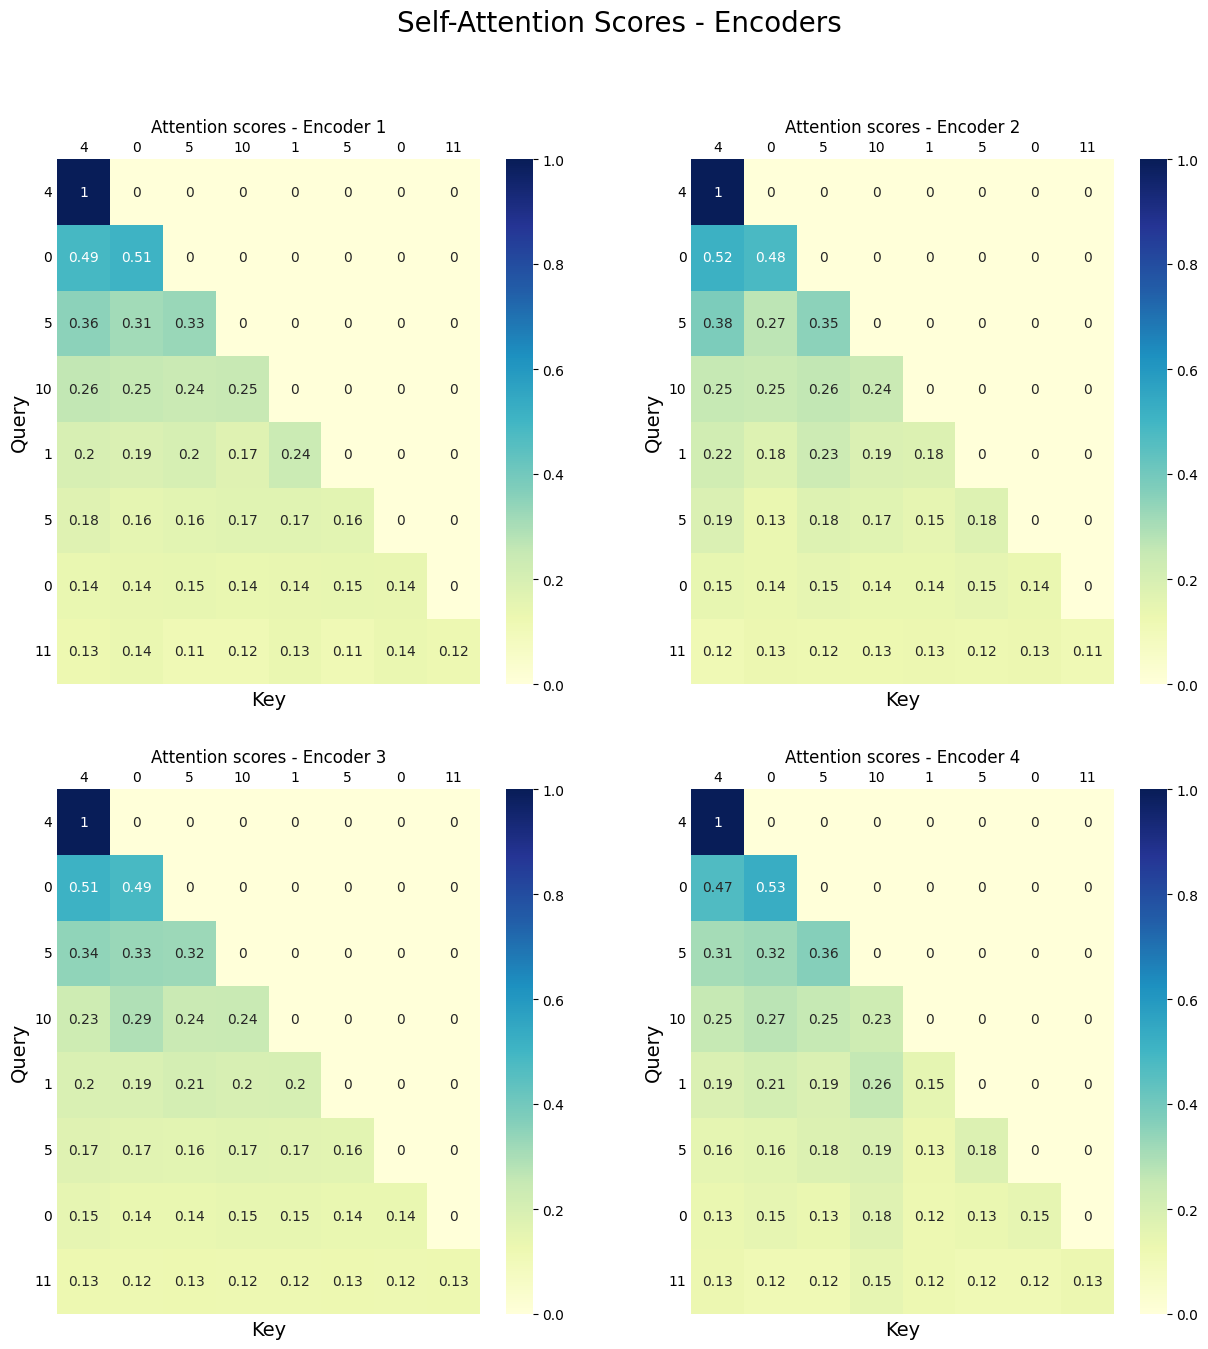

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.heatmap(scores1.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[0, 0])
axs[0, 0].set_title("Attention scores - Encoder 1")

sns.heatmap(scores2.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[0, 1])
axs[0, 1].set_title("Attention scores - Encoder 2")

sns.heatmap(scores3.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[1, 0])
axs[1, 0].set_title("Attention scores - Encoder 3")

sns.heatmap(scores4.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[1, 1])
axs[1, 1].set_title("Attention scores - Encoder 4")

input_items = [i.item() for i in inputs_soft[0]]

for ax in axs.flat:
    ax.set_xticks(np.arange(len(input_items)) + 0.5)
    ax.set_yticks(np.arange(len(input_items)) + 0.5)
    ax.set_xticklabels(input_items, ha='center')
    ax.set_yticklabels(input_items, rotation=0, va='center')
    ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
    ax.tick_params(axis='y', length=0)
    ax.set_xlabel("Key", fontsize=14)
    ax.set_ylabel("Query", fontsize=14)

plt.suptitle("Self-Attention Scores - Encoders", fontsize=20)
plt.show()

In [67]:
decoder = transformer.decoder[-1]
scores1, att = decoder.self_attention_head.attention_heads[0](outputs)

decoder = transformer.decoder[-2]
scores2, att = decoder.self_attention_head.attention_heads[0](outputs)

decoder = transformer.decoder[-3]
scores3, att = decoder.self_attention_head.attention_heads[0](outputs)

decoder = transformer.decoder[-4]
scores4, att = decoder.self_attention_head.attention_heads[0](outputs)

In [68]:
scores1 = scores1[0]
scores2 = scores2[0]
scores3 = scores3[0]
scores4 = scores4[0]

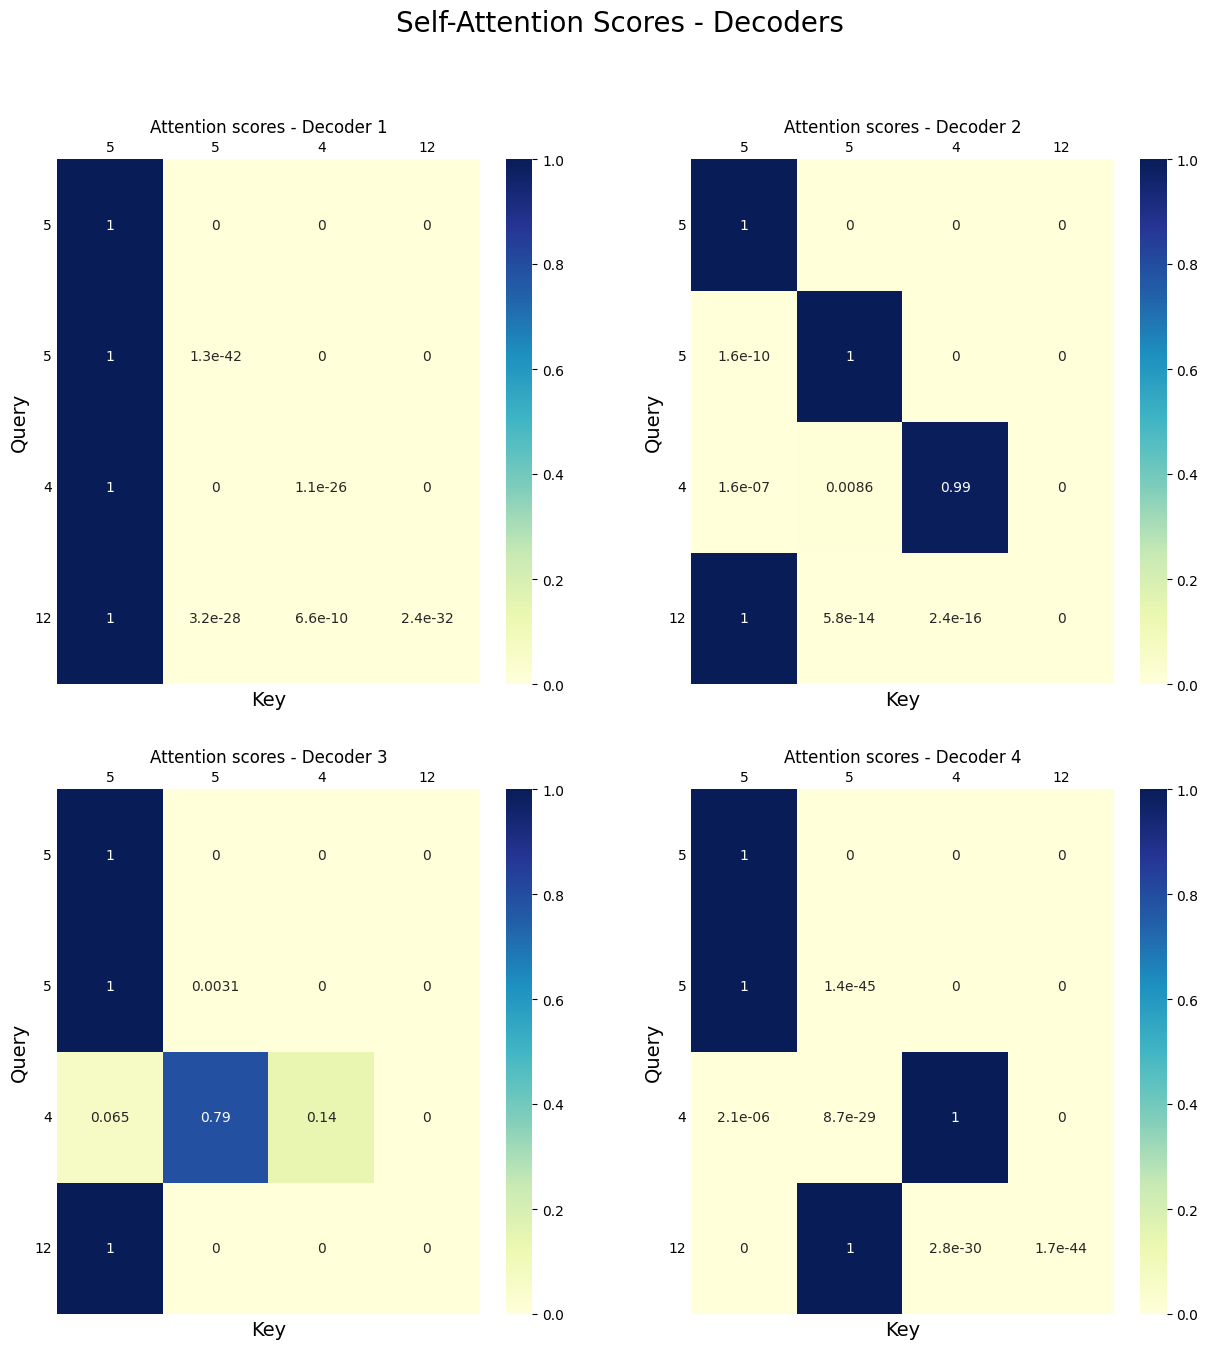

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.heatmap(scores1.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[0, 0])
axs[0, 0].set_title("Attention scores - Decoder 1")

sns.heatmap(scores2.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[0, 1])
axs[0, 1].set_title("Attention scores - Decoder 2")

sns.heatmap(scores3.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[1, 0])
axs[1, 0].set_title("Attention scores - Decoder 3")

sns.heatmap(scores4.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[1, 1])
axs[1, 1].set_title("Attention scores - Decoder 4")

output_items = [i.item() for i in outputs_soft[0]]

for ax in axs.flat:
    ax.set_xticks(np.arange(len(output_items)) + 0.5)
    ax.set_yticks(np.arange(len(output_items)) + 0.5)
    ax.set_xticklabels(output_items, ha='center')
    ax.set_yticklabels(output_items, rotation=0, va='center')
    ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
    ax.tick_params(axis='y', length=0)
    ax.set_xlabel("Key", fontsize=14)
    ax.set_ylabel("Query", fontsize=14)

plt.suptitle("Self-Attention Scores - Decoders", fontsize=20)
plt.show()

In [70]:
encoded_inputs = transformer._encode(inputs.float())

decoder = transformer.decoder[-1]
scores1, att = decoder.cross_attention_head.attention_heads[0](outputs, encoded_inputs)

decoder = transformer.decoder[-2]
scores2, att = decoder.cross_attention_head.attention_heads[0](outputs, encoded_inputs)

decoder = transformer.decoder[-3]
scores3, att = decoder.cross_attention_head.attention_heads[0](outputs, encoded_inputs)

decoder = transformer.decoder[-4]
scores4, att = decoder.cross_attention_head.attention_heads[0](outputs, encoded_inputs)

In [71]:
scores1 = scores1[0]
scores2 = scores2[0]
scores3 = scores3[0]
scores4 = scores4[0]

Text(0.5, 0.98, 'Cross Attention scores - Decoder')

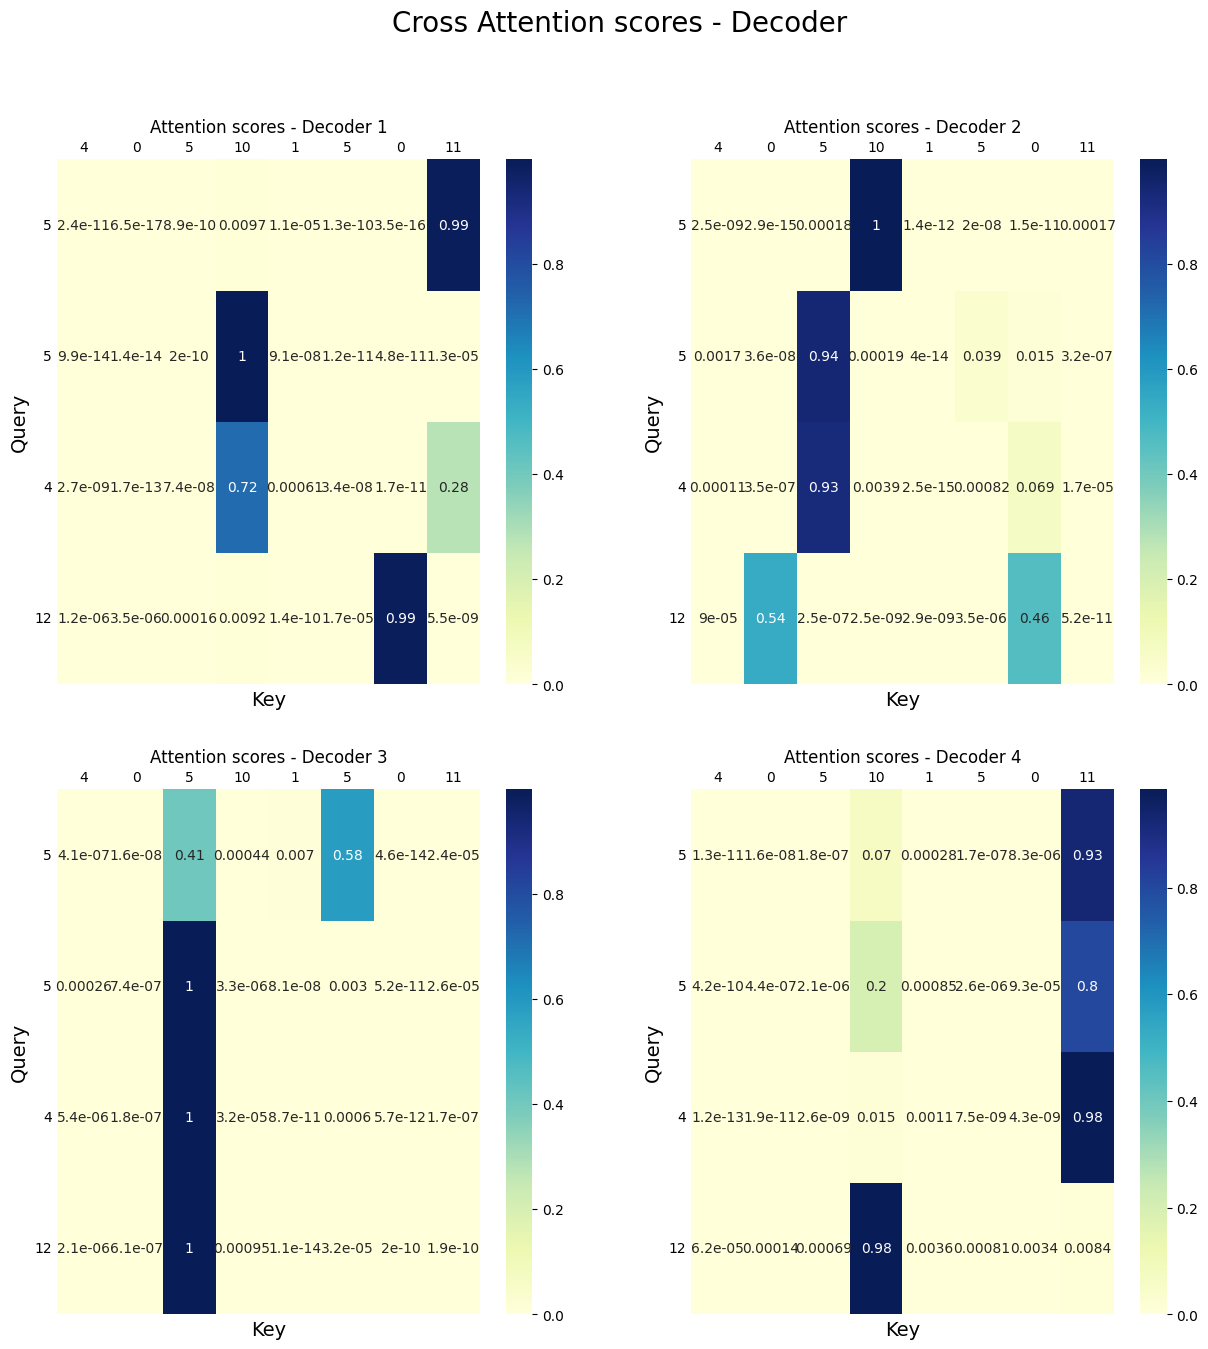

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.heatmap(scores1.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[0, 0])
axs[0, 0].set_title("Attention scores - Decoder 1")

sns.heatmap(scores2.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[0, 1])
axs[0, 1].set_title("Attention scores - Decoder 2")

sns.heatmap(scores3.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[1, 0])
axs[1, 0].set_title("Attention scores - Decoder 3")

sns.heatmap(scores4.cpu().detach().numpy(), annot=True, cmap="YlGnBu", ax=axs[1, 1])
axs[1, 1].set_title("Attention scores - Decoder 4")

output_items = [i.item() for i in outputs_soft[0]]
input_items = [i.item() for i in inputs_soft[0]]

for ax in axs.flat:
    ax.set_xticks(np.arange(len(input_items)) + 0.5)
    ax.set_yticks(np.arange(len(output_items)) + 0.5)
    ax.set_xticklabels(input_items, ha='center')
    ax.set_yticklabels(output_items, rotation=0, va='center')
    ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
    ax.tick_params(axis='y', length=0)
    ax.set_xlabel("Key", fontsize=14)
    ax.set_ylabel("Query", fontsize=14)

plt.suptitle("Cross Attention scores - Decoder", fontsize=20)

Ahora sí, primero evaluamos el modelo con datos con los que este ya fue entrenado:

In [90]:
def symbols_to_string(symbols, idx2char):
    return "".join([idx2char[symbol.item()] for symbol in symbols])

In [91]:
inputs = inputs.cpu()
outputs = outputs.cpu()
targets = targets.cpu()

In [92]:
inputs = torch.argmax(inputs, dim=-1)
outputs = torch.argmax(outputs, dim=-1)
targets = torch.argmax(targets, dim=-1)

In [93]:
for i in range(10):
    print("Input:", symbols_to_string(inputs[i], dataset.idx2char))
    print("Predicción:", symbols_to_string(outputs[i], dataset.idx2char))
    print("Target:", symbols_to_string(targets[i], dataset.idx2char))
    print('')

Input: 263+127=
Predicción: 399e
Target: 390e

Input: 250+141=
Predicción: 391e
Target: 391e

Input: 359+111=
Predicción: 460e
Target: 470e

Input: 192+225=
Predicción: 417e
Target: 417e

Input: 402+353=
Predicción: 754e
Target: 755e

Input: 100+208=
Predicción: 318e
Target: 308e

Input: 495+115=
Predicción: 609e
Target: 610e

Input: 167+313=
Predicción: 479e
Target: 480e

Input: 439+310=
Predicción: 759e
Target: 749e

Input: 127+144=
Predicción: 270e
Target: 271e



Ahora, evaluémoslo para datos que aún no ha visto:

In [180]:
def test_model(test_seq):
    test = [dataset.char2idx[char] for char in test_seq]

    test = torch.tensor(test).unsqueeze(0)
    test = F.one_hot(test, num_classes=len(dataset.vocab))

    test = test.to(device)

    output = transformer(test.float(), targets.float().to(device), teacher_forcing_ratio=0)
    output = torch.argmax(output, dim=-1)

    output = output.cpu()

    print("Input:", test_seq)
    print("Predicción:", symbols_to_string(output[0], dataset.idx2char))

    return symbols_to_string(output[0], dataset.idx2char)

In [194]:
def test_sequence(test_seq):
    num1, num2 = test_seq.split('+')
    num2 = num2.split('=')[0]

    num1 = int(num1)
    num2 = int(num2)

    seq = f"{test_seq}{num1 + num2:03.0f}e"

    contained = seq in sequences
    if not contained:
        print(f'La secuencia "{seq}" no está en el dataset de entrenamiento\n')

    output = test_model(test_seq)
    result = output[:-1]

    if int(result) == (num1 + num2):
        print("Resultado correcto")

    else:
        print("Resultado incorrecto")
        diff = abs(int(result) - (num1 + num2))
        print(f"Diferencia: {diff}")



Algunos casos correctos son los siguientes:

In [ ]:
test_sequence("499+106=")

La secuencia "499+106=605e" no está en el dataset de entrenamiento

Input: 499+106=
Predicción: 605e
Resultado correcto


In [237]:
print("(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499")
test_sequence("001+000=")

(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499
La secuencia "001+000=001e" no está en el dataset de entrenamiento

Input: 001+000=
Predicción: 001e
Resultado correcto


In [196]:
test_sequence("403+300=")

La secuencia "403+300=703e" no está en el dataset de entrenamiento

Input: 403+300=
Predicción: 712e
Resultado incorrecto
Diferencia: 9


In [238]:
print("(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499")
test_sequence("001+230=")

(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499
La secuencia "001+230=231e" no está en el dataset de entrenamiento

Input: 001+230=
Predicción: 231e
Resultado correcto


In [239]:
print("(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499")
test_sequence("011+330=")

(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499
La secuencia "011+330=341e" no está en el dataset de entrenamiento

Input: 011+330=
Predicción: 341e
Resultado correcto


In [201]:
test_sequence("116+330=")

Input: 116+330=
Predicción: 446e
Resultado correcto


In [216]:
test_sequence("422+430=")

La secuencia "422+430=852e" no está en el dataset de entrenamiento

Input: 422+430=
Predicción: 851e
Resultado incorrecto
Diferencia: 1


In [240]:
print("(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499")
test_sequence("000+000=")

(*) NOTA: El modelo solo fue entrenado para sumas de número entre 100 y 499
La secuencia "000+000=000e" no está en el dataset de entrenamiento

Input: 000+000=
Predicción: 000e
Resultado correcto


A la luz de los resultados obtenidos, podemos afirmar que el modelo es capaz de ajustarse a la perfección a conjuntos de datos complejos, concluyendo así una buena implementación de la arquitectura Transformer.